# Music Genre Classification

## Giới thiệu

Dataset Music Genre Classification là bộ dữ liệu gồm các bản nhạc hoặc các đặc trưng trích xuất từ âm thanh (như MFCC, chroma, spectral contrast…), được gán nhãn theo từng thể loại (genre). Mục tiêu của bộ dữ liệu là xây dựng mô hình học máy có khả năng phân loại bản nhạc vào đúng thể loại như Pop, Rock, Jazz, Classical, Hip-Hop… dựa trên các đặc trưng âm thanh. Đây là một bài toán phổ biến trong lĩnh vực Music Information Retrieval (MIR), giúp hệ thống hiểu và phân tích dữ liệu âm nhạc ở mức độ cao hơn. Dataset thường bao gồm tập huấn luyện và tập kiểm tra ở dạng bảng (tabular features), cho phép áp dụng nhiều mô hình machine learning để dự đoán thể loại nhạc.

### Import thư viện

In [61]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl

from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, f1_score, balanced_accuracy_score
from sklearn.decomposition import PCA

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

### Load dữ liệu

In [62]:
train_df = pd.read_csv('./data/train.csv')
test_df = pd.read_csv('./data/test.csv')

## Exploratory Data Analysis - EDA

### Tổng quan dữ liệu

In [63]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14396 entries, 0 to 14395
Data columns (total 18 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Id                  14396 non-null  int64  
 1   Artist Name         14396 non-null  object 
 2   Track Name          14396 non-null  object 
 3   Popularity          14063 non-null  float64
 4   danceability        14396 non-null  float64
 5   energy              14396 non-null  float64
 6   key                 12787 non-null  float64
 7   loudness            14396 non-null  float64
 8   mode                14396 non-null  int64  
 9   speechiness         14396 non-null  float64
 10  acousticness        14396 non-null  float64
 11  instrumentalness    10855 non-null  float64
 12  liveness            14396 non-null  float64
 13  valence             14396 non-null  float64
 14  tempo               14396 non-null  float64
 15  duration_in min/ms  14396 non-null  float64
 16  time

Bộ dữ liệu **Music Genre Classification** gồm:
- **14396 dòng (mẫu)**  
- **17 cột (biến đặc trưng)**

→ Trong đó, **biến mục tiêu (target)** là `Class` — Thể loại bản nhạc.

In [64]:
train_df.describe()

,Id,Popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_in min/ms,time_signature,Class
count,14396.000000,14063.000000,14396.000000,14396.000000,12787.000000,14396.000000,14396.000000,14396.000000,14396.000000,10855.000000,14396.000000,14396.000000,14396.000000,1.439600e+04,14396.000000,14396.000000
mean,7198.500000,44.525208,0.543105,0.662422,5.953781,-7.900852,0.640247,0.080181,0.246746,0.178129,0.195782,0.486379,122.695372,2.000942e+05,3.924354,6.695679
std,4155.911573,17.418940,0.165517,0.235967,3.200013,4.057362,0.479944,0.085157,0.310922,0.304266,0.159258,0.239476,29.538490,1.116891e+05,0.359520,3.206170
min,1.000000,1.000000,0.059600,0.001210,1.000000,-39.952000,0.000000,0.022500,0.000000,0.000001,0.011900,0.021500,30.557000,5.016500e-01,1.000000,0.000000
25%,3599.750000,33.000000,0.432000,0.508000,3.000000,-9.538000,0.000000,0.034800,0.004280,0.000088,0.097275,0.299000,99.799000,1.654458e+05,4.000000,5.000000
50%,7198.500000,44.000000,0.545000,0.699000,6.000000,-7.013500,1.000000,0.047100,0.081450,0.003920,0.129000,0.480500,120.060000,2.089410e+05,4.000000,8.000000
75%,10797.250000,56.000000,0.658000,0.861000,9.000000,-5.162000,1.000000,0.083100,0.432250,0.201000,0.256000,0.672000,141.988250,2.522470e+05,4.000000,10.000000
max,14396.000000,100.000000,0.989000,1.000000,11.000000,1.342000,1.000000,0.955000,0.996000,0.996000,0.992000,0.986000,217.416000,1.477187e+06,5.000000,10.000000


### Tóm tắt thông tin các feature

In [65]:
train_df.head()

,Id,Artist Name,Track Name,Popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_in min/ms,time_signature,Class
0,1,Marina Maximilian,Not Afraid,37.0,0.334,0.536,9.0,-6.649,0,0.0381,0.378000,NaN,0.106,0.235,152.429,204947.0,4,9
1,2,The Black Keys,Howlin' for You,67.0,0.725,0.747,11.0,-5.545,1,0.0876,0.027200,0.0468,0.104,0.380,132.921,191956.0,4,6
2,3,Royal & the Serpent,phuck u,NaN,0.584,0.804,7.0,-6.094,1,0.0619,0.000968,0.6350,0.284,0.635,159.953,161037.0,4,10
3,4,Detroit Blues Band,Missing You,12.0,0.515,0.308,NaN,-14.711,1,0.0312,0.907000,0.0213,0.300,0.501,172.472,298093.0,3,2
4,5,Coast Contra,My Lady,48.0,0.565,0.777,6.0,-5.096,0,0.2490,0.183000,NaN,0.211,0.619,88.311,254145.0,4,5


In [66]:
test_df.tail()

,Id,Artist Name,Track Name,Popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_in min/ms,time_signature
3595,17992,Within Temptation,Stand My Ground,55.0,0.271,0.866,5.0,-4.072,0,0.0578,0.04890,0.000762,0.1160,0.127,175.665,267987.0,4
3596,17993,Dikla,◊©◊ë◊ï◊¢◊ô◊ô◊ù,38.0,0.598,0.690,5.0,-4.758,0,0.3030,0.36300,NaN,0.0519,0.653,187.934,198300.0,4
3597,17994,Cut Copy,Hearts On Fire - Calvin Harris Remix,18.0,0.783,0.820,1.0,-6.102,1,0.0489,0.00054,0.499000,0.0628,0.235,129.015,339213.0,4
3598,17995,Jethro Tull,Thick as a Brick - Edit #1,38.0,0.443,0.401,5.0,-13.997,1,0.0426,0.26300,NaN,0.1680,0.751,168.209,182587.0,3
3599,17996,MIKA,Grace Kelly,69.0,0.675,0.828,NaN,-5.799,1,0.0454,0.02420,0.010200,0.3640,0.669,122.229,187733.0,4


🎯 Biến mục tiêu
- `Class`: Thể loại của bản nhạc — Đây là nhãn mà mô hình cần dự đoán, ví dụ: Pop, Rock, Jazz, Electronic,...

🎤 Thông tin về nghệ sĩ và bài hát
- `Artist Name`: Tên nghệ sĩ hoặc ban nhạc thể hiện bài hát.
- `Track Name`: Tên bài hát hoặc tựa đề của bản nhạc.
- `Popularity`: Mức độ phổ biến của bài hát (giá trị càng cao → càng nổi tiếng).

🎶 Đặc trưng âm nhạc dựa trên cảm nhận và cấu trúc
- `danceability`: Mức độ phù hợp để nhảy (0–1). Được đánh giá dựa trên nhịp điệu, độ ổn định của beat và tốc độ.
- `energy`: Mức độ năng lượng hoặc độ “mạnh mẽ” của bản nhạc (0–1). Các bài nhanh, nhiều bass, nhiều nhịp trống thường có giá trị cao.
- `valence`: Chỉ số thể hiện "cảm xúc tích cực" của bài hát (0–1).
- `tempo`: Tốc độ bài nhạc tính bằng BPM (beats per minute). Chỉ số này phản ánh nhịp độ nhanh hay chậm của ca khúc.

🎼 Thông tin về cấu trúc âm nhạc
- `key`: Tông của bản nhạc. Là số nguyên ánh xạ theo chuẩn Pitch Class.
- `mode`: Giọng nhạc của bài hát
- `time_signature`: Chỉ số nhịp (ví dụ: 4/4, 3/4). Cho biết số nhịp trong mỗi ô nhịp và giá trị nốt tương ứng với 1 nhịp.

🔊 Các đặc trưng âm thanh do thuật toán trích xuất
- `loudness`: Độ lớn âm thanh của toàn bài hát (tính bằng decibel – dB).
Giá trị âm thấp hơn (nhỏ hơn 0) → bài hát nhỏ hơn.
- `speechiness`: Mức độ “giọng nói” trong bài nhạc.
- `acousticness`: Mức độ “acoustic” của bài hát (0–1). Giá trị cao → bài hát thuần nhạc cụ mộc (guitar, piano,...).
- `instrumentalness`: Mức độ khả năng bài hát không có giọng hát.
- `liveness`: Mức độ bài hát được trình diễn trực tiếp (live).

⏱️ Thông tin về thời lượng
- `duration_in min/ms`: Thời gian bài hát tính bằng milli–giây (ms).

### Dữ liệu thiếu (Missing values)

In [67]:
def display_missing_data(df):
    missing = df.isnull().sum()
    missing = missing[missing > 0].sort_values(ascending=False)
    percent = (missing / len(df)) * 100
    print(pd.DataFrame({'Giá trị thiếu': missing, 'Phần trăm (%)': percent.round(2)}))

display_missing_data(train_df)

                  Giá trị thiếu  Phần trăm (%)
instrumentalness           3541          24.60
key                        1609          11.18
Popularity                  333           2.31


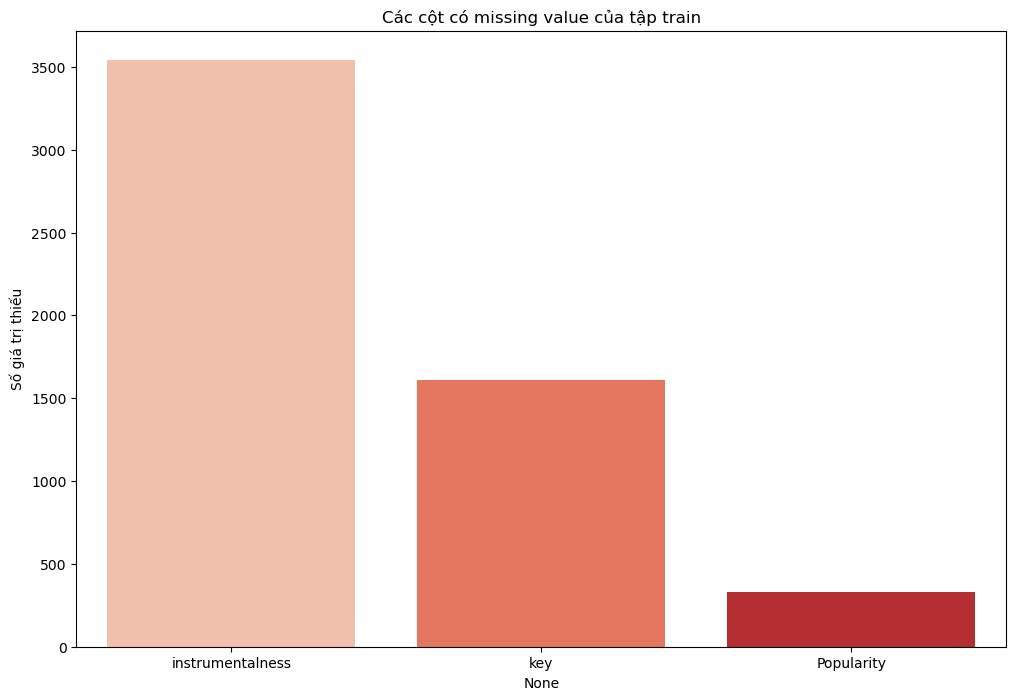

In [68]:
missing = train_df.isnull().sum()
missing = missing[missing > 0].sort_values(ascending=False)
plt.figure(figsize=(12,8))
sns.barplot(x=missing.index, y=missing.values, palette="Reds")
plt.ylabel("Số giá trị thiếu")
plt.title("Các cột có missing value của tập train")
plt.show()

In [69]:
display_missing_data(test_df)

                  Giá trị thiếu  Phần trăm (%)
instrumentalness            836          23.22
key                         405          11.25
Popularity                   95           2.64


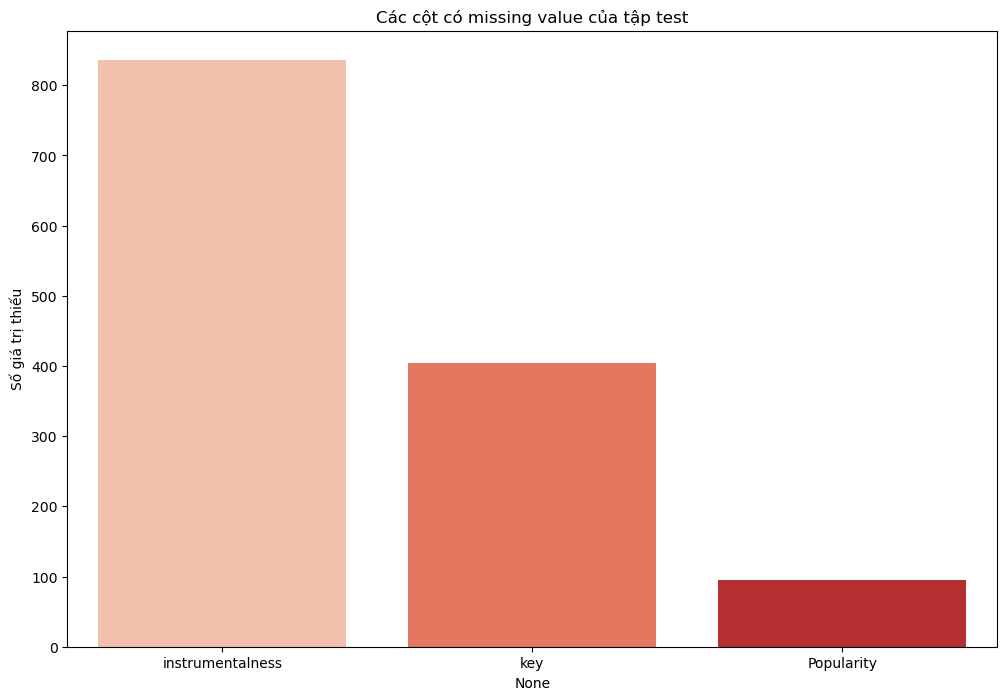

In [70]:
missing = test_df.isnull().sum()
missing = missing[missing > 0].sort_values(ascending=False)
plt.figure(figsize=(12,8))
sns.barplot(x=missing.index, y=missing.values, palette="Reds")
plt.ylabel("Số giá trị thiếu")
plt.title("Các cột có missing value của tập test")
plt.show()

### Chi tiết các cột dữ liệu bị thiếu và giá trị

- `instrumentalness`: Khoảng  gần 1/4 số bài hát không có thông tin về mức độ nhạc cụ (không có vocal).
- `key`: Khoảng 11% dữ liệu thiếu, tức là một số bài hát không xác định được tone (nốt cơ bản).
- `Popularity`: Khoảng 2% dữ liệu thiếu, là mức độ phổ biến của bài hát, một số bản nhạc chưa có chỉ số này.

### Phân tích biến mục tiêu: `Class`

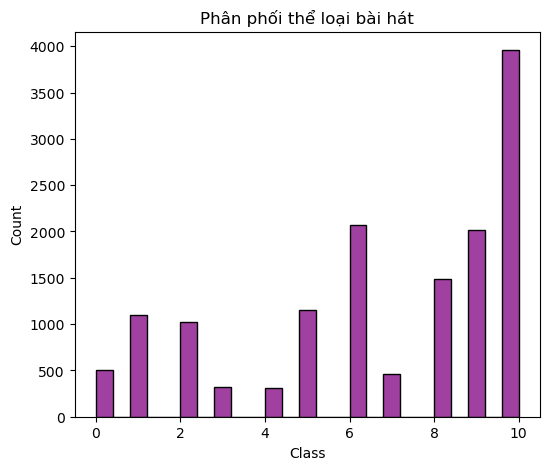

In [71]:
plt.figure(figsize=(6,5))
sns.histplot(train_df['Class'], color='purple')
plt.title('Phân phối thể loại bài hát')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

**Nhận xét:**

- Một số lớp (Class) có số lượng bản nhạc lớn hơn hẳn, ví dụ Class 10 là phổ biến nhất với gần 4000 bản.
- Một số lớp ít bài hơn, như Class 0, Class 3, Class 4, chỉ khoảng vài trăm bản.
- Dữ liệu bị không cân bằng (imbalanced).

### Phân loại biến
- **Kiểu số (numeric):** 16 cột.
- **Kiểu phân loại (categorical):** 2 cột.

In [72]:
numeric_features = train_df.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = train_df.select_dtypes(include=['object']).columns.tolist()

print(f"Số cột numeric: {len(numeric_features)}")
print(list(numeric_features))
print(f"Số cột categorical: {len(categorical_features)}")
print(list(categorical_features))

Số cột numeric: 16
['Id', 'Popularity', 'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_in min/ms', 'time_signature', 'Class']
Số cột categorical: 2
['Artist Name', 'Track Name']


1. **`Biến số (Numeric) – 16 cột`**

- **Liên tục (Continuous):** Popularity, danceability, energy, loudness, speechiness, acousticness, instrumentalness, liveness, valence, tempo, duration_in min/ms

- **Rời rạc (Discrete / Count):** Id, key, mode, time_signature, Class

2. **`Biến phân loại (Categorical) – 2 cột`**

- **Thông tin bài hát / nghệ sĩ:** Artist Name, Track Name

#### Categorical features

#### Numeric features

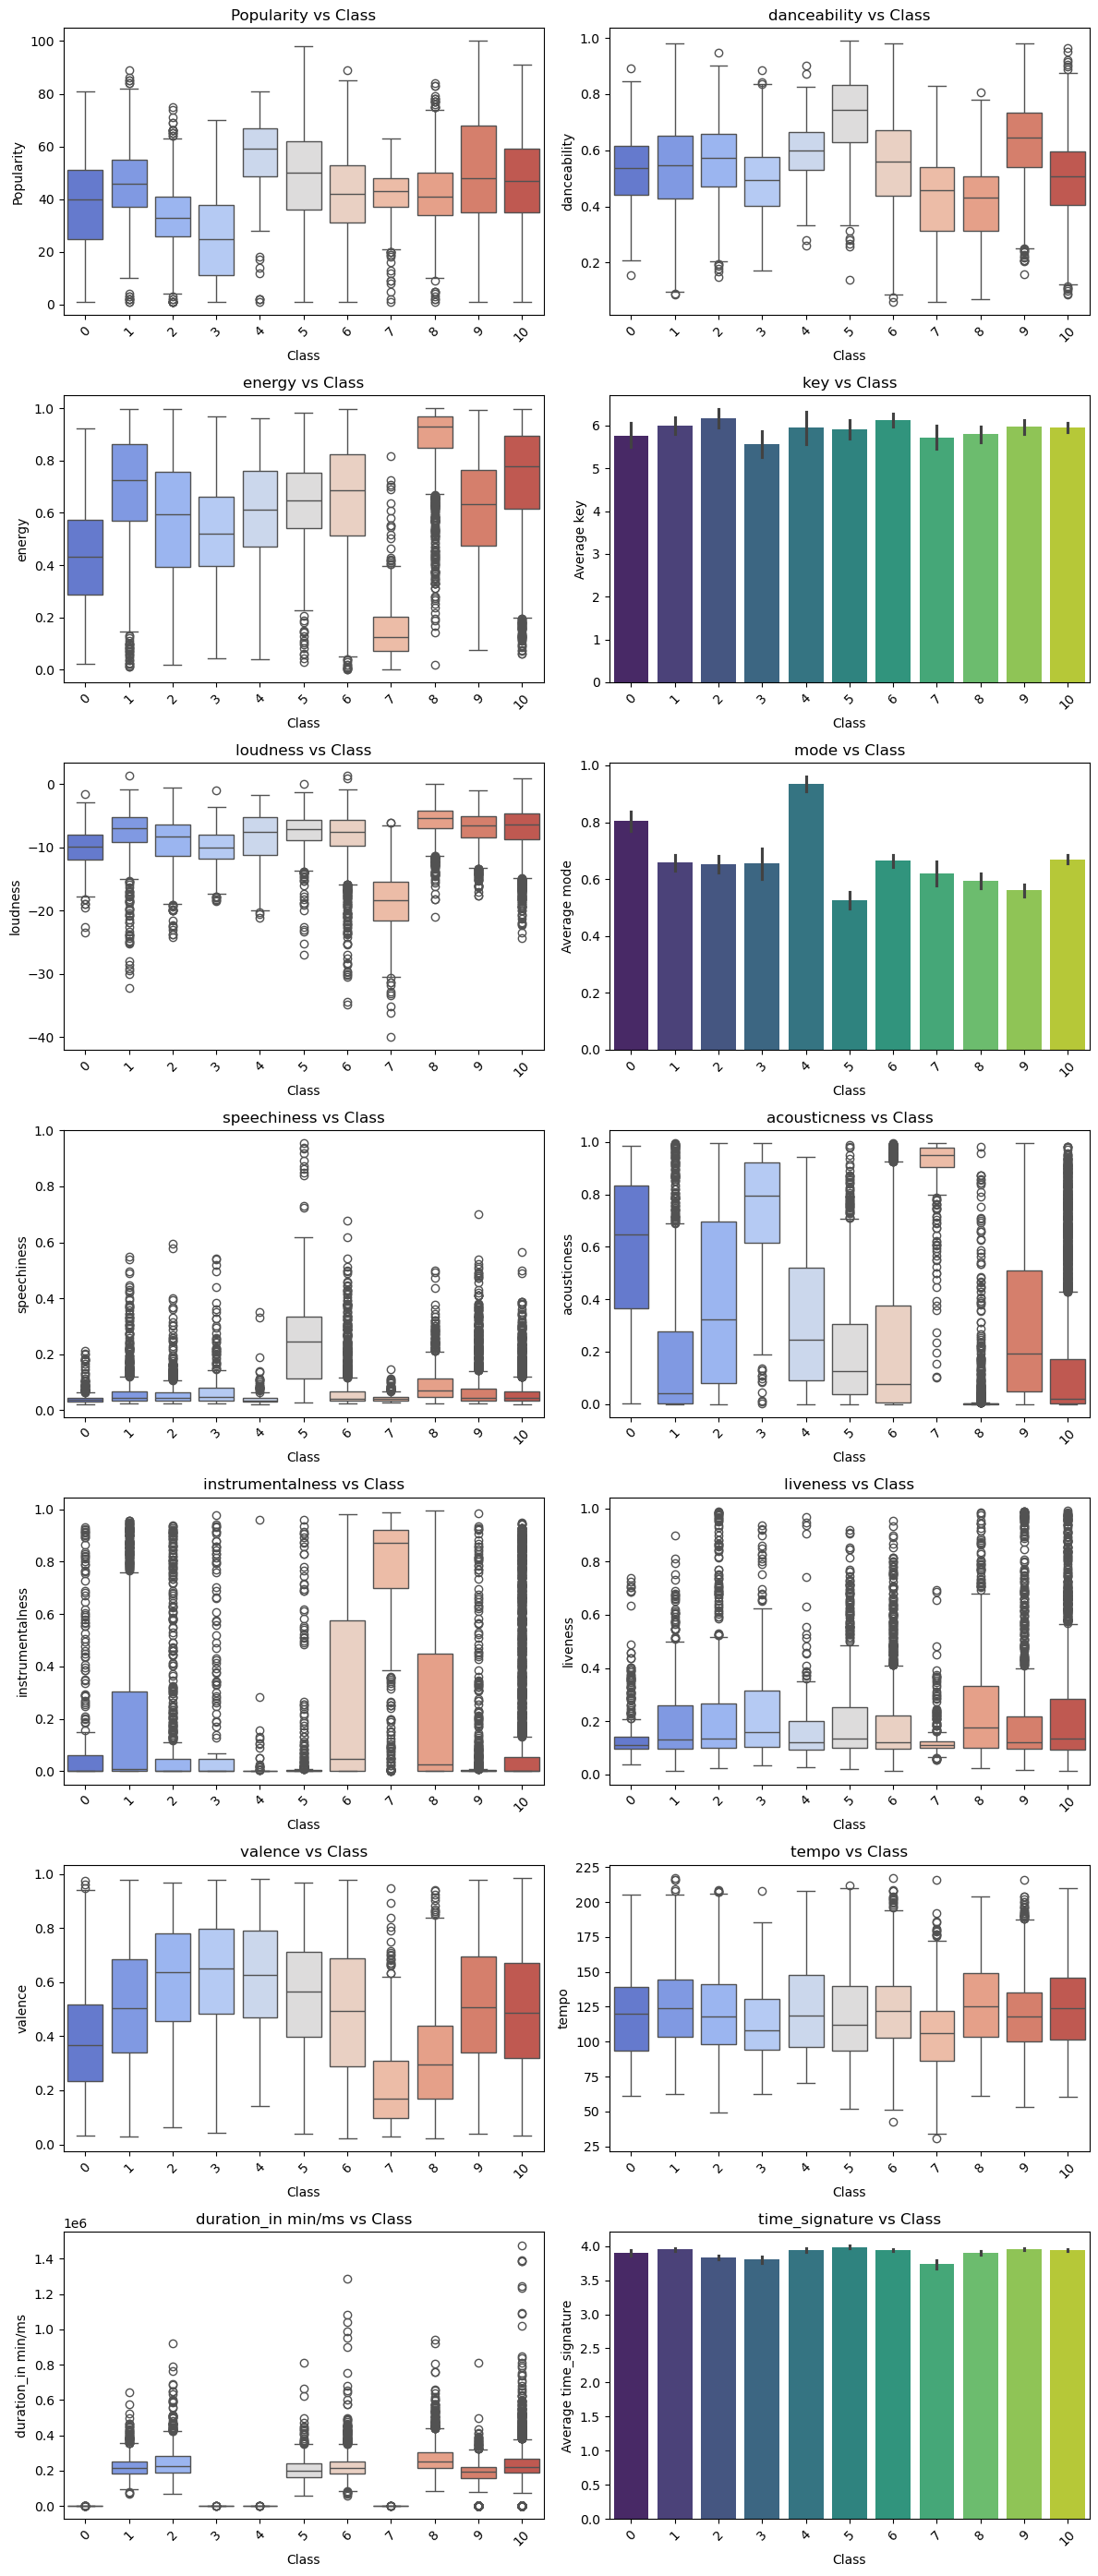

In [73]:
numeric_features = [
    'Popularity', 'danceability', 'energy', 'key', 'loudness', 
    'mode', 'speechiness', 'acousticness', 'instrumentalness', 
    'liveness', 'valence', 'tempo', 'duration_in min/ms', 'time_signature'
]

target = 'Class'

n_feats = len(numeric_features)
n_cols = 2
n_rows = (n_feats + n_cols - 1) // n_cols

fig, ax = plt.subplots(n_rows, n_cols, figsize=(n_cols * 6, n_rows * 4))
ax = ax.flatten()

for i, col in enumerate(numeric_features):
    if train_df[col].nunique() < 20:
        # Numeric ít giá trị: barplot trung bình theo Class
        sns.barplot(
            data=train_df,
            x=target,
            y=col,
            palette='viridis',
            ax=ax[i],
            estimator='mean'
        )
        ax[i].set_ylabel(f'Average {col}')
    else:
        # Numeric liên tục: boxplot theo Class
        sns.boxplot(
            data=train_df,
            x=target,
            y=col,
            palette='coolwarm',
            ax=ax[i]
        )
        ax[i].set_ylabel(col)
    
    ax[i].set_title(f'{col} vs {target}', fontsize=12)
    ax[i].set_xlabel(target)
    ax[i].tick_params(axis='x', rotation=45)

# Ẩn các ô trống nếu số biến không chia hết cho grid
for j in range(i + 1, len(ax)):
    ax[j].set_visible(False)

plt.tight_layout()
plt.show()

**Nhận xét:**

**1. Popularity**

- Các thể loại nhạc (`Class`) có mức độ phổ biến khác nhau.

- Một số `Class` như 4, 5, 9 có giá trị trung bình và biến thiên cao hơn, trong khi các `Class` khác thấp hơn.

- Nhiều outlier xuất hiện, cho thấy một số bài cực kỳ phổ biến trong từng `Class`.

**2. Danceability, Energy, Valence, Tempo**

- `Danceability`, `Energy`, `Valence` phân bố khá khác nhau giữa các `Class`.

- Một số `Class` có median cao (ví dụ `Class` 5 về danceability), một số `Class` thấp hơn.

- `Tempo` cũng có sự biến thiên lớn, một số `Class` có các bài cực nhanh hoặc cực chậm, nhưng median khá tương đồng.

**3. Key, Mode, Time_signature**

- `Key`, `Mode`, `Time_signature` là các biến rời rạc, hiển thị dưới dạng barplot.

- Không có sự khác biệt quá lớn giữa các `Class`, tức nhạc của các `Class` thường sử dụng các `key/mode/time_signature` phổ biến tương tự.

**4. Loudness**

- `Loudness` có sự khác biệt giữa các `Class` nhưng không quá rõ rệt.

- Một số outlier âm thanh cực kỳ to hoặc nhỏ tồn tại, đặc biệt ở `Class` 6, 7.

**5. Speechiness, Acousticness, Instrumentalness, Liveness**

- `Instrumentalness`: Một số `Class` có giá trị cao hơn, thể hiện nhiều nhạc không lời (`Class` 6, 7).

- `Speechiness`: `Class` 4 có median cao hơn, có thể chứa nhiều bài rap hoặc spoken word.

- `Acousticness`: Một số `Class` như 2, 4, 6 có giá trị thấp, nhạc chủ yếu điện tử hoặc mạnh.

- `Liveness`: Đa phần các `Class` có median thấp, nhưng một số outlier có giá trị cao, có thể là nhạc live.

**6. Duration_in min/ms**

- Thời lượng bài hát khác nhau giữa các `Class` nhưng median khá tương đồng.

- Một số `Class` có bài cực dài hoặc cực ngắn (outlier), cho thấy sự đa dạng trong thể loại.

**Kết luận tổng quan:**

- Một số numeric features như `danceability`, `energy`, `valence`, `instrumentalness`, `speechiness` phân biệt `Class` khá tốt.
- Các biến như `key`, `mode`, `time_signature` ít giúp phân biệt `Class`, vì các giá trị trung bình tương tự giữa các `Class`.
- Outlier xuất hiện ở hầu hết các features, đặc biệt với `popularity`, `loudness`, `tempo`, `duration`. Khi xây dựng mô hình, có thể cân nhắc xử lý outlier hoặc chuẩn hóa dữ liệu.

##### Ma trận tương quan của Numeric features

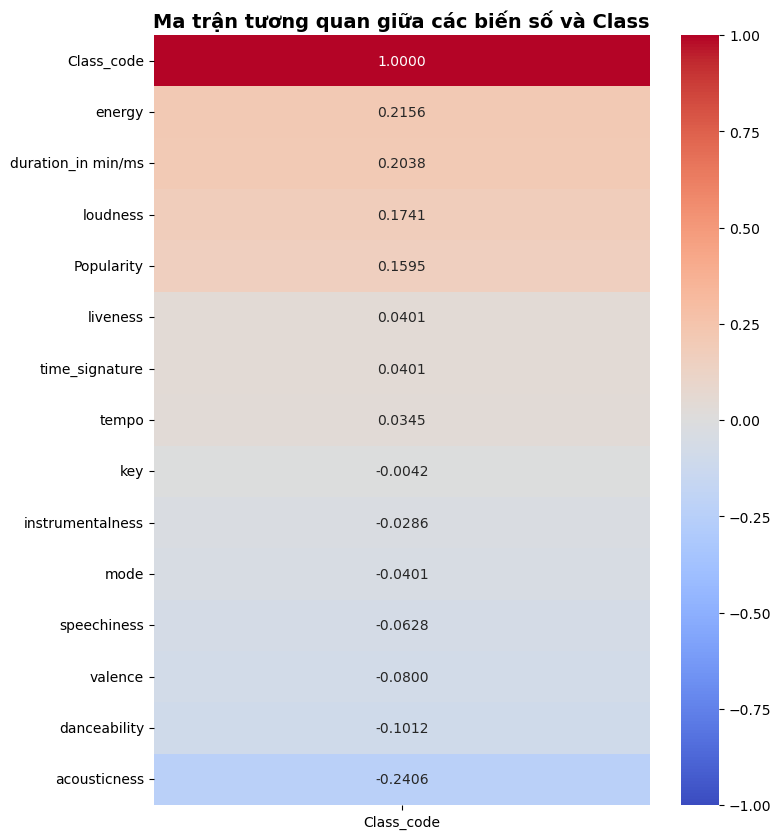

In [74]:
# Lấy DataFrame chỉ gồm các cột numeric
numeric_df = train_df[numeric_features]

# Tính ma trận tương quan
corr = numeric_df.corr()

# Nếu muốn tính tương quan với target 'Class' hoặc 'genre', chuyển target sang numeric
if 'Class' in train_df.columns:
    train_df['Class_code'] = train_df['Class'].astype('category').cat.codes
    numeric_df['Class_code'] = train_df['Class_code']  # thêm cột Class_code vào DataFrame
    class_corr = numeric_df.corr()['Class_code'].sort_values(ascending=False).to_frame()
    
    plt.figure(figsize=(8, 10))
    sns.heatmap(class_corr, annot=True, cmap='coolwarm', fmt=".4f", vmin=-1, vmax=1)
    plt.title("Ma trận tương quan giữa các biến số và Class", fontsize=14, fontweight='bold')
    plt.show()

**Nhận xét ma trận tương quan:**

- Các đặc trưng `energy`, `duration_in_min/ms`, `loudness` và `Popularity` có tương quan dương nhẹ với `Class`, nhưng mức độ không cao (≈ 0.15–0.21).

- `acousticness` có tương quan âm mạnh nhất với `Class` (≈ –0.24), cho thấy đây có thể là một trong những đặc trưng phân biệt thể loại tốt hơn.

- Các đặc trưng khác như `danceability`, `valence`, `speechiness`, `instrumentalness`, `tempo`, `key`, `mode`, `time_signature`... đều có tương quan rất thấp (gần 0), nghĩa là ít ảnh hưởng trực tiếp đến nhãn `Class`.

- Tổng thể, mối quan hệ tuyến tính giữa các đặc trưng audio và `Class` khá yếu, do đó mô hình phân loại thể loại nhạc sẽ cần các thuật toán phi tuyến (`XGBoost`, `CatBoost`, `LightGBM`...) để khai thác mối quan hệ phức tạp hơn.

## Feature Engineering

In [75]:
train_df["energy_dance"] = train_df["energy"] * train_df["danceability"]
test_df["energy_dance"] = test_df["energy"] * test_df["danceability"]

train_df["energy_valence"] = train_df["energy"] * train_df["valence"]
test_df["energy_valence"] = test_df["energy"] * test_df["valence"]

train_df["acoustic_instr"] = train_df["acousticness"] * train_df["instrumentalness"]
test_df["acoustic_instr"] = test_df["acousticness"] * test_df["instrumentalness"]

train_df["tempo_bin"] = (train_df["tempo"] // 20).astype(int)
test_df["tempo_bin"] = (test_df["tempo"] // 20).astype(int)

train_df["is_fast"] = (train_df["tempo"] > 120).astype(int)
test_df["is_fast"] = (test_df["tempo"] > 120).astype(int)

train_df["duration_minutes"] = train_df["duration_in min/ms"] / 60000
test_df["duration_minutes"] = test_df["duration_in min/ms"] / 60000

train_df["is_loud"] = (train_df["loudness"] > -5).astype(int)
test_df["is_loud"] = (test_df["loudness"] > -5).astype(int)

train_df["energy_dance_ratio"] = train_df["energy"] / (train_df["danceability"] + 1e-6)
test_df["energy_dance_ratio"] = test_df["energy"] / (test_df["danceability"] + 1e-6)

**1. Interaction features**
- `energy_dance`: Kết hợp mức năng lượng và độ danceability, giúp mô hình nhận biết các bài nhạc có độ “sôi động” cao.
- `energy_valence`: Kết hợp năng lượng và cảm xúc tích cực, giúp phân biệt nhạc vui (pop/dance) và nhạc trầm (blues/classical).
- acous`tic_instr: Đo mức acoustic và instrumental cùng lúc, hỗ trợ nhận diện các thể loại như classical, ambient, instrumental.

**2. Tempo features**
- `tempo_bin`: Chia tempo thành các nhóm 20 BPM để giảm nhiễu và phân loại nhạc chậm/nhanh rõ ràng hơn.
- `is_fast`: Nhịp nhanh (>120 BPM), phù hợp phân biệt EDM, pop dance với các thể loại chậm.

**3. Duration feature**
- `duration_minutes`: Chuyển thời lượng sang phút để dễ so sánh và mô hình dễ học hơn, hữu ích vì một số genre (classical/jazz) thường có bài dài.

**4. Loudness feature**
- `is_loud`: Gắn nhãn bài có âm lượng lớn, giúp phân biệt nhạc hiện đại (âm lượng cao) với classical hoặc acoustic.

**5. Ratio feature**
- `energy_dance_ratio`: Tỉ lệ năng lượng so với danceability, hỗ trợ phân biệt rock/metal (năng lượng cao, dance thấp) với funk/disco.

## Preprocessing

In [76]:
train_features = train_df.drop(columns=['Id', 'Class','Class_code'])
test_features = test_df.drop(columns=['Id'])

numeric_cols = train_features.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = train_features.select_dtypes(include=['object', 'category']).columns.tolist()

Loại bỏ `Id`, `Class`, `Class_code` giúp tránh rò rỉ thông tin và giữ lại đúng các feature để train.
 
Dữ liệu được tách thành numeric_cols và cat_cols để dễ xử lý:

- Numeric dùng cho impute/scale.
- Categorical dùng cho encoding.

Việc phân loại này giúp xây dựng pipeline preprocessing chính xác và rõ ràng hơn.

In [77]:
# Impute numeric with median, categorical with 'None'
num_imputer = SimpleImputer(strategy="median")
cat_imputer = SimpleImputer(strategy="constant", fill_value="None")

if len(numeric_cols) > 0:
    train_num = pd.DataFrame(num_imputer.fit_transform(train_features[numeric_cols]), columns=numeric_cols, index=train_features.index)
    test_num = pd.DataFrame(num_imputer.transform(test_features[numeric_cols]), columns=numeric_cols, index=test_features.index)
else:
    train_num = pd.DataFrame(index=train_features.index)
    test_num = pd.DataFrame(index=test_features.index)

if len(cat_cols) > 0:
    train_cat = pd.DataFrame(cat_imputer.fit_transform(train_features[cat_cols]), columns=cat_cols, index=train_features.index)
    test_cat = pd.DataFrame(cat_imputer.transform(test_features[cat_cols]), columns=cat_cols, index=test_features.index)
else:
    train_cat = pd.DataFrame(index=train_features.index)
    test_cat = pd.DataFrame(index=test_features.index)

- `Numeric features` được xử lý bằng median imputation, giúp thay thế giá trị thiếu bằng trung vị — phù hợp với dữ liệu có nhiều ngoại lệ.
- `Categorical features` được thay missing bằng "None" để mô hình hiểu rằng đó là một giá trị riêng, không bị mất thông tin.
- Code kiểm tra nếu danh sách cột rỗng thì tạo DataFrame trống, tránh lỗi khi transform.
- Việc tách riêng numeric và categorical giúp đảm bảo mỗi nhóm được xử lý đúng kỹ thuật impute.

### Encode

In [78]:
# Encode categorical: label encoding for high-cardinality; one-hot for low-cardinality (<=10)
encoded_train_cat = []
encoded_test_cat = []
for c in cat_cols:
    n_unique = train_cat[c].nunique()
    if n_unique <= 10:
        # one-hot
        dtr = pd.get_dummies(train_cat[c], prefix=c, dummy_na=False)
        dte = pd.get_dummies(test_cat[c], prefix=c, dummy_na=False)
        # align columns
        dtr, dte = dtr.align(dte, join="outer", axis=1, fill_value=0)
        encoded_train_cat.append(dtr)
        encoded_test_cat.append(dte)
    else:
        # label encode (fit on combined to avoid unseen)
        le = LabelEncoder()
        combined = pd.concat([train_cat[c], test_cat[c]]).astype(str)
        le.fit(combined)
        encoded_train_cat.append(pd.Series(le.transform(train_cat[c].astype(str)), name=c, index=train_cat.index))
        encoded_test_cat.append(pd.Series(le.transform(test_cat[c].astype(str)), name=c, index=test_cat.index))

if len(encoded_train_cat) > 0:
    X_train_cat = pd.concat(encoded_train_cat, axis=1)
    X_test_cat = pd.concat(encoded_test_cat, axis=1)
else:
    X_train_cat = pd.DataFrame(index=train_features.index)
    X_test_cat = pd.DataFrame(index=test_features.index)

- Với các categorical có số lượng giá trị ≤ 10, code dùng One-Hot Encoding, giúp mô hình học tốt hơn nhờ biến thành các cột nhị phân rõ ràng.
- Với các categorical nhiều giá trị (high-cardinality), code dùng Label Encoding, tránh tạo quá nhiều cột và giảm kích thước dữ liệu.
- Khi one-hot, train và test được align cột để đảm bảo cấu trúc giống hệt, tránh lỗi khi dự đoán.
- Với Label Encoding, bộ mã hoá được fit trên train + test để tránh trường hợp test có giá trị chưa từng thấy.

Cuối cùng, tất cả các cột đã encode được ghép lại thành `X_train_cat` và `X_test_cat`, đảm bảo dữ liệu sạch và nhất quán để đưa vào model.

In [79]:
X_train_raw = pd.concat([train_num.reset_index(drop=True), X_train_cat.reset_index(drop=True)], axis=1)
X_test_raw = pd.concat([test_num.reset_index(drop=True), X_test_cat.reset_index(drop=True)], axis=1)

print(f"After encoding: X_train_raw shape: {X_train_raw.shape}, X_test_raw shape: {X_test_raw.shape}")

After encoding: X_train_raw shape: (14396, 24), X_test_raw shape: (3600, 24)


- Đoạn code ghép `numeric` đã impute và `categorical` đã encode thành hai bộ dữ liệu hoàn chỉnh: X_train_raw và X_test_raw.
- Việc reset_index(drop=True) đảm bảo không bị lệch index khi concat hai nhóm cột.
- Sau khi kết hợp, dữ liệu đã sạch missing, encode đầy đủ và sẵn sàng đưa vào mô hình.

In [80]:
# Scale numeric features
scaler = StandardScaler()
# Only scale numeric columns (the ones originally numeric)
scaled_train_num = pd.DataFrame(scaler.fit_transform(train_num), columns=numeric_cols, index=train_num.index) if len(numeric_cols)>0 else pd.DataFrame(index=train_num.index)
scaled_test_num = pd.DataFrame(scaler.transform(test_num), columns=numeric_cols, index=test_num.index) if len(numeric_cols)>0 else pd.DataFrame(index=test_num.index)

- Đoạn code dùng StandardScaler để chuẩn hóa các biến số học về phân phối có mean = 0 và std = 1.
- Việc scale chỉ áp dụng cho numeric columns, tránh làm sai ý nghĩa của các biến đã one-hot hoặc label-encoded.
- Scaler được fit trên train và transform trên test, đảm bảo không rò rỉ thông tin từ test vào train.

Kết quả là `scaled_train_num` và `scaled_test_num` có giá trị chuẩn hóa, giúp mô hình học ổn định hơn.

In [81]:
X_train = pd.concat([scaled_train_num.reset_index(drop=True), X_train_cat.reset_index(drop=True)], axis=1)
X_test = pd.concat([scaled_test_num.reset_index(drop=True), X_test_cat.reset_index(drop=True)], axis=1)

# Keep label encoder for final mapping
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(train_df['Class'].astype(str))
class_names = label_encoder.classes_
n_classes = len(class_names)
print(f"Detected {n_classes} classes: {class_names}")

Detected 11 classes: ['0' '1' '10' '2' '3' '4' '5' '6' '7' '8' '9']


- Đoạn code ghép lại numeric đã scale và categorical đã encode để tạo thành bộ dữ liệu cuối cùng X_train và X_test.

- LabelEncoder được dùng để mã hóa cột Class thành các giá trị số (y), giúp mô hình phân loại hoạt động đúng.

- class_names và n_classes được lưu lại để sử dụng khi đánh giá hoặc tạo file submission.

## Models Training

- `XGBoost`: Mô hình boosting dạng cây rất mạnh cho các bài toán phân loại, học theo kiểu tăng cường dần từng cây để giảm lỗi.

- `LightGBM`: LightGBM là mô hình gradient boosting tối ưu cho tốc độ, rất mạnh và chạy nhanh khi số feature lớn.

- `CatBoost`: Boosting dựa trên cây nhị phân, tối ưu tự nhiên cho categorical (mặc dù bạn đã encode), ổn định, ít cần tuning.

In [82]:
models = {
    "XGBoost": XGBClassifier(
        objective="multi:softprob",
        use_label_encoder=False,
        eval_metric="mlogloss",
        n_estimators=300,
        learning_rate=0.05,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.7,
        random_state=RANDOM_STATE,
        verbosity=0
    ),
    "LightGBM": LGBMClassifier(
        objective="multiclass",
        n_estimators=1000,
        learning_rate=0.05,
        num_leaves=64,
        colsample_bytree=0.7,
        subsample=0.8,
        random_state=RANDOM_STATE,
        n_jobs=-1
    ),
    "CatBoost": CatBoostClassifier(
        iterations=1000,
        learning_rate=0.05,
        depth=6,
        random_seed=RANDOM_STATE,
        verbose=0,
        allow_writing_files=False
    )
}

- **Tham số của mô hình:**

> **XGBoost**
- objective="multi:softprob" → phân loại nhiều lớp, xuất ra xác suất từng lớp.
- n_estimators=300 → số lượng cây xây dựng.
- learning_rate=0.05 → tốc độ học, nhỏ giúp mô hình ổn định hơn.
- max_depth=6 → độ sâu tối đa mỗi cây, kiểm soát độ phức tạp.
- subsample=0.8 → lấy 80% dữ liệu cho mỗi cây để chống overfitting.
- colsample_bytree=0.7 → lấy 70% số feature mỗi cây.
- random_state → cố định kết quả.
- verbosity=0 → tắt log.
> **LightGBM**
- objective="multiclass" → phân loại nhiều lớp.
- n_estimators=1000 → số cây nhiều hơn XGBoost (LightGBM chạy nhanh hơn).
- learning_rate=0.05 → tốc độ học.
- num_leaves=64 → số lá tối đa, tăng khả năng mô hình hoá.
- colsample_bytree=0.7 → lấy 70% số feature.
- subsample=0.8 → lấy 80% dữ liệu mỗi vòng.
- n_jobs=-1 → dùng toàn bộ CPU.
> **CatBoost**
- iterations=1000 → số cây (số vòng boosting).
- learning_rate=0.05 → tốc độ học.
- depth=6 → độ sâu của cây.
- random_seed → tái lập kết quả.
- verbose=0 → tắt log.
- allow_writing_files=False → tắt ghi file tạm của CatBoost.

## Evaluation

In [83]:
def evaluate_models(models, X, y, n_splits=5):
    """Cross-validation cho nhiều models và trả về DataFrame tóm tắt."""
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=RANDOM_STATE)
    results = []

    for name, model in models.items():
        print(f"\nModel: {name}")
        acc_list, f1_list, bal_list = [], [], []

        for fold, (tr_idx, val_idx) in enumerate(skf.split(X, y), 1):
            X_tr, X_val = X.iloc[tr_idx], X.iloc[val_idx]
            y_tr, y_val = y[tr_idx], y[val_idx]

            model.fit(X_tr, y_tr)
            y_pred = model.predict(X_val)

            acc_list.append(accuracy_score(y_val, y_pred))
            f1_list.append(f1_score(y_val, y_pred, average="macro"))
            bal_list.append(balanced_accuracy_score(y_val, y_pred))

            print(f" Fold {fold}: acc={acc_list[-1]:.4f}, f1={f1_list[-1]:.4f}")

        results.append({
            "model": name,
            "acc_mean": np.mean(acc_list),
            "f1_mean": np.mean(f1_list),
            "bal_mean": np.mean(bal_list)
        })

    return pd.DataFrame(results).sort_values("f1_mean", ascending=False)

print("\n=== Cross-validation (short version) ===")
df_cv = evaluate_models(models, X_train, y)
print("\nSummary:")
print(df_cv)


=== Cross-validation (short version) ===

Model: XGBoost
 Fold 1: acc=0.5573, f1=0.6067
 Fold 2: acc=0.5533, f1=0.5882
 Fold 3: acc=0.5644, f1=0.6094
 Fold 4: acc=0.5672, f1=0.6013
 Fold 5: acc=0.5457, f1=0.5993

Model: LightGBM
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000876 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4467
[LightGBM] [Info] Number of data points in the train set: 11516, number of used features: 24
[LightGBM] [Info] Start training from score -3.360028
[LightGBM] [Info] Start training from score -2.572708
[LightGBM] [Info] Start training from score -1.290953
[LightGBM] [Info] Start training from score -2.648305
[LightGBM] [Info] Start training from score -3.802417
[LightGBM] [Info] Start training from score -3.838064
[LightGBM] [Info] Start training from score -2.521699
[LightGBM] [Info] Start

- Thực hiện Stratified K-Fold cross-validation cho các mô hình.

- Tính các metric: `accuracy`, `macro F1`, `balanced accuracy`.

- Lấy trung bình các metric trên tất cả fold để đánh giá hiệu suất tổng thể.

- Trả về DataFrame tóm tắt, giúp dễ dàng so sánh và chọn mô hình tốt nhất.

In [84]:
print("\nTraining final models on full training data...")
trained_models = {}
test_proba = np.zeros((X_test.shape[0], n_classes))

for i, (name, model) in enumerate(models.items()):
    print(f"Fitting {name} on full data...")
    model.fit(X_train, y)
    trained_models[name] = model

    proba = model.predict_proba(X_test)
    test_proba += proba


Training final models on full training data...
Fitting XGBoost on full data...
Fitting LightGBM on full data...
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000952 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4469
[LightGBM] [Info] Number of data points in the train set: 14396, number of used features: 24
[LightGBM] [Info] Start training from score -3.360098
[LightGBM] [Info] Start training from score -2.573460
[LightGBM] [Info] Start training from score -1.290959
[LightGBM] [Info] Start training from score -2.649110
[LightGBM] [Info] Start training from score -3.800154
[LightGBM] [Info] Start training from score -3.838133
[LightGBM] [Info] Start training from score -2.521120
[LightGBM] [Info] Start training from score -1.939885
[LightGBM] [Info] Start training from score -3.441308
[LightGBM] [Info] Start training

- Huấn luyện các mô hình cuối cùng trên toàn bộ tập X_train, y để tận dụng hết dữ liệu.

**Với từng mô hình:**
- Gọi fit trên toàn bộ dữ liệu train.
- Dự đoán xác suất (`predict_proba`) trên tập test.

Kết quả xác suất được cộng dồn vào `test_proba`, chuẩn bị cho bước ensemble hoặc trung bình dự đoán cuối cùng. Giữ mô hình đã train trong `trained_models` để sử dụng lại mà không cần huấn luyện lại.

## Mô hình kết hợp

In [85]:
weights = []
for name in models.keys():
    row = df_cv[df_cv["model"] == name]
    if not row.empty:
        weights.append(float(row["f1_mean"].values[0]))
    else:
        weights.append(1.0)

weights = np.array(weights)
if weights.sum() == 0:
    weights = np.ones_like(weights)
weights = weights / weights.sum()

# Recompute weighted proba properly
weighted_proba = np.zeros_like(test_proba)
for w, (name, model) in zip(weights, models.items()):
    p = trained_models[name].predict_proba(X_test)
    weighted_proba += w * p

# Final predicted labels (indices)
test_pred_idx = np.argmax(weighted_proba, axis=1)
test_pred_labels = label_encoder.inverse_transform(test_pred_idx)

- Tạo trọng số (weights) cho mỗi mô hình dựa trên f1_mean từ kết quả cross-validation, mô hình tốt hơn sẽ có trọng số cao hơn.
- Nếu không tìm thấy giá trị f1_mean, mặc định trọng số là 1.
- Chuẩn hóa trọng số để tổng bằng 1, tránh bias khi cộng xác suất.
- Tính xác suất dự đoán có trọng số (weighted_proba) bằng cách nhân xác suất mỗi mô hình với trọng số tương ứng và cộng lại.
- Lấy nhãn dự đoán cuối cùng bằng argmax trên xác suất kết hợp.
- Chuyển từ chỉ số nhãn về label gốc (test_pred_labels) nhờ label_encoder, sẵn sàng cho đánh giá hoặc submission.

In [86]:
def evaluate_weighted_ensemble(trained_models, weights, X, y):
    # Chuẩn hóa trọng số
    weights = np.array(weights)
    if weights.sum() == 0:
        weights = np.ones_like(weights)
    weights = weights / weights.sum()

    # Tính xác suất weighted ensemble
    proba = np.zeros((X.shape[0], len(np.unique(y))))
    for w, (name, model) in zip(weights, trained_models.items()):
        proba += w * model.predict_proba(X)

    # Nhãn dự đoán cuối cùng
    y_pred_idx = np.argmax(proba, axis=1)

    # Tính metric
    acc = accuracy_score(y, y_pred_idx)
    f1 = f1_score(y, y_pred_idx, average="macro")
    bal = balanced_accuracy_score(y, y_pred_idx)

    # Lưu vào DataFrame
    df = pd.DataFrame([{
        "model": "Weighted_Ensemble",
        "acc_mean": acc,
        "f1_mean": f1,
        "bal_mean": bal
    }])

    return df

df_ensemble = evaluate_weighted_ensemble(trained_models, weights, X_train, y)
print("\nWeighted Ensemble Performance:")
print(df_ensemble)



Weighted Ensemble Performance:
               model  acc_mean   f1_mean  bal_mean
0  Weighted_Ensemble  0.916782  0.936973  0.927776


- Hàm `evaluate_weighted_ensemble()` giúp đánh giá trực tiếp hiệu suất của mô hình ensemble sau khi đã gộp xác suất từ các mô hình con.

- Trọng số được chuẩn hóa, đảm bảo tổng bằng 1 để tránh sai lệch khi cộng xác suất.

- Ensemble được tạo bằng cách kết hợp xác suất dự đoán từ từng mô hình theo mức độ quan trọng (weights) thu được từ cross-validation.

- Nhãn dự đoán cuối cùng được lấy bằng argmax trên xác suất tổng hợp, phản ánh sự “bỏ phiếu có trọng số” của các mô hình.

- Hàm trả về một DataFrame tóm tắt gồm `Accuracy`, `Macro F1` và `Balanced Accuracy` — giống format kết quả của hàm evaluate_models, giúp dễ dàng so sánh hiệu suất giữa ensemble và từng mô hình đơn lẻ.

## Xuất ra file kết quả

In [87]:
submission = pd.DataFrame({
    "Id": test_df['Id'],
    "Class": test_pred_labels
})

submission.to_csv("submission_weight.csv", index=False)
print("\nSaved: submission_weight.csv")

# Also save per-model submissions (optional)
for name, model in trained_models.items():
    preds_idx = np.argmax(model.predict_proba(X_test), axis=1)
    preds_labels = label_encoder.inverse_transform(preds_idx)
    sub = pd.DataFrame({"Id": test_df['Id'], "Class": preds_labels})
    fname = f"submission_{name}.csv"
    sub.to_csv(fname, index=False)
    print(f"Saved: {fname}")


Saved: submission_weight.csv
Saved: submission_XGBoost.csv
Saved: submission_LightGBM.csv
Saved: submission_CatBoost.csv


- Tạo file submission cuối cùng (submission_weight.csv) từ nhãn dự đoán của mô hình kết hợp (weighted_proba).
- Lưu Id và Class để nộp hoặc đánh giá kết quả.
- Ngoài ra, tùy chọn lưu từng submission riêng cho mỗi mô hình (submission_XGBoost.csv, submission_LightGBM.csv, submission_CatBoost.csv).
- Giúp so sánh hiệu quả giữa mô hình cá nhân và mô hình kết hợp, đồng thời phục vụ việc thử nghiệm ensemble khác trong tương lai.

In [88]:
# !jupyter nbconvert --to script Code_music.ipynb

# Kết thúc